<h1>Neural Network</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_boston, make_circles, make_classification, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler


from IPython.display import HTML

<h3>Let's define some loss functions we will optimize (with treir derivatives)</h3>

In [2]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_derivative(y_true, y_pred):
    return -2 * (y_true - y_pred) / len(y_true)

def log_loss(y_true, a_pred):
    return np.mean(-y_true * np.log(a_pred) - (1 - y_true) * np.log(1 - a_pred))

def log_loss_derivative(y_true, a_pred):
    return (-y_true / a_pred + (1 - y_true) / (1 - a_pred)) / len(y_true)

<h3>Define some activation functions as well</h3>

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = 1 / (1 + np.exp(-z))
    return s * (1 - s)

def tanh(z):
    return np.tanh(z);

def tanh_derivative(z):
    return 1 - np.tanh(z) ** 2;

def RElU(z):
    return np.maximum(0, z)

def RElU_derivative(z):
    return (z > 0).astype(int)

<p>Let's define some typical NN layers</p>

In [4]:
class Linear:
    '''
    Linear class permorms ordinary FC layer in neural networks
    Parameters:
    n_input - size of input neurons
    n_output - size of output neurons
    Methods:
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    '''
    def __init__(self, n_input, n_output):
        self.n_input = n_input
        self.n_output = n_output
        self.w = np.random.normal(scale=np.sqrt(2/(n_input + n_output)), size=(n_input, n_output)) # He initialization
        self.b = np.random.normal(scale=np.sqrt(2/(n_input + n_output)), size=(1, n_output))
        
    def forward(self, x):
        self.input = x
        return x.dot(self.w) + self.b
    
    def backward(self, output_error, learning_rate):
        '''
        Backpropagation
        '''
        w_grad = self.input.T.dot(output_error) # weights gradient
        b_grad = np.ones((1, len(output_error))).dot(output_error) # bias gradient
        input_error = output_error.dot(self.w.T) # error of the input is used as the output_error of the previous layer
        
        #update weights
        self.w -= learning_rate * w_grad
        self.b -= learning_rate * b_grad
        return input_error # return the error for the previous layer
    
    def __repr__(self):
        return f'Linear layer, input size:{self.n_input}, output size:{self.n_output}'
    
class Activation:
    '''
    Activation class is used for activation function of the FC layer
    Params:
    activation_function - activation function (e.g. sigmoid, RElU, tanh)
    activation_derivative - derivative of the activation function
    Methods:
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    '''
    def __init__(self, activation_function, activation_derivative):
        self.activation = activation_function
        self.derivative = activation_derivative
        
    def forward(self, x):
        self.input = x
        return self.activation(x)
    
    def backward(self, output_error, learning_rate):
        return output_error * self.derivative(self.input)
    
    def __repr__(self):
        return f'Activation layer, activation function:{self.activation}'

In [5]:
class NeuralNetwork:
    '''
    NeuralNetwork class is used to build the Neural Network and train it
    Methods:
    use(loss, loss_derivative) - set the loss function and it's derivative
    add_layer(layer) - constructor of the NN, add one of the layers described above
    predict(x) - forward pass through the network
    fit(x, y, learning_rate, n_epochs, x_val, y_val) - fit the network
    '''
    def __init__(self):
        self.layers = []
        
    def use(self, loss, loss_derivative):
        self.loss = loss
        self.loss_derivative = loss_derivative
        
    def add_layer(self, layer):
        self.layers.append(layer)
        
    def predict(self, x):
        prediction = x
        for layer in self.layers:
            prediction = layer.forward(prediction)
        return prediction
    
    def fit(self, x, y, learning_rate, n_epochs, x_val=None, y_val=None):
        
        loss_print_epoch = n_epochs / 10 # print the loss 10 times
        
        for _ in range(n_epochs):
            preds = self.predict(x) # predict the output
            err = self.loss(y, preds) # calculate the loss, only for printing
            output_error = self.loss_derivative(y, preds) # calculate the error to start backpropagation
            
            for layer in reversed(self.layers):
                output_error = layer.backward(output_error, learning_rate) # backward pass
                
            if x_val is not None and y_val is not None: # print the loss for the validation set
                err_val = self.loss(y_val, self.predict(x_val))
                if _ % loss_print_epoch == 0:
                    print('*' * 30)
                    print(f'Epoch {_}  train_loss:{err}, val_loss:{err_val}')
            else:
                if _ % loss_print_epoch == 0:
                    print('*' * 30)
                    print(f'Epoch {_}  train_loss:{err}')
            
            
        return self
    
    def __repr__(self):
        return f'NeuralNetwork class, layers:\n{self.layers}'

<p>Let's solve the XOR problem first</p>

In [6]:
x_XOR = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_XOR = np.array([[0], [1], [1], [0]])

In [7]:
nn = NeuralNetwork()
nn.use(log_loss, log_loss_derivative)
nn.add_layer(Linear(2, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(4, 1))
nn.add_layer(Activation(sigmoid, sigmoid_derivative))

In [8]:
nn.fit(x_XOR, y_XOR, 0.1, 1000)

******************************
Epoch 0  train_loss:0.7657694705482506
******************************
Epoch 100  train_loss:0.663568080308981
******************************
Epoch 200  train_loss:0.570229947406677
******************************
Epoch 300  train_loss:0.37892713596523575
******************************
Epoch 400  train_loss:0.2189847538687974
******************************
Epoch 500  train_loss:0.13707287410129254
******************************
Epoch 600  train_loss:0.09541063836549388
******************************
Epoch 700  train_loss:0.07178970757370251
******************************
Epoch 800  train_loss:0.05700625798184172
******************************
Epoch 900  train_loss:0.047027440446502894


NeuralNetwork class, layers:
[Linear layer, input size:2, output size:4, Activation layer, activation function:<function tanh at 0x0000015A56E79B88>, Linear layer, input size:4, output size:1, Activation layer, activation function:<function sigmoid at 0x0000015A56E79A68>]

In [9]:
nn.predict(x_XOR) 

array([[0.01575147],
       [0.95623083],
       [0.95442204],
       [0.05096069]])

<p>Looks good, let's try some different tasks</p>

In [10]:
def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 1000)
    x2s = np.linspace(axes[2], axes[3], 1000)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = np.round(clf.predict(X_new)).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][(y==0).reshape(-1)], X[:, 1][(y==0).reshape(-1)], "yo")
        plt.plot(X[:, 0][(y==1).reshape(-1)], X[:, 1][(y==1).reshape(-1)], "bs")
        plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [11]:
data = load_iris()
x = data['data'][data['target'] != 2][:, 2:4]
y = data['target'][data['target'] != 2].reshape(-1, 1)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)

In [13]:
nn = NeuralNetwork()
nn.use(log_loss, log_loss_derivative)
nn.add_layer(Linear(2, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(4, 1))
nn.add_layer(Activation(sigmoid, sigmoid_derivative))

In [14]:
nn.fit(x_train, y_train, 0.03, 10000, x_val, y_val)

******************************
Epoch 0  train_loss:0.8179798923227847, val_loss:0.8829036753797566
******************************
Epoch 1000  train_loss:0.03380517762591806, val_loss:0.03149924422301878
******************************
Epoch 2000  train_loss:0.012890204873140966, val_loss:0.011635858250188934
******************************
Epoch 3000  train_loss:0.007674640556377329, val_loss:0.006818916727815463
******************************
Epoch 4000  train_loss:0.005390346159842081, val_loss:0.0047407507587789105
******************************
Epoch 5000  train_loss:0.0041255491477030235, val_loss:0.0036018432346355497
******************************
Epoch 6000  train_loss:0.0033278846501949427, val_loss:0.002889098404098868
******************************
Epoch 7000  train_loss:0.0027812349340484046, val_loss:0.0024036340678631005
******************************
Epoch 8000  train_loss:0.00238434868701835, val_loss:0.002052948985516351
******************************
Epoch 9000  train_l

NeuralNetwork class, layers:
[Linear layer, input size:2, output size:4, Activation layer, activation function:<function tanh at 0x0000015A56E79B88>, Linear layer, input size:4, output size:1, Activation layer, activation function:<function sigmoid at 0x0000015A56E79A68>]

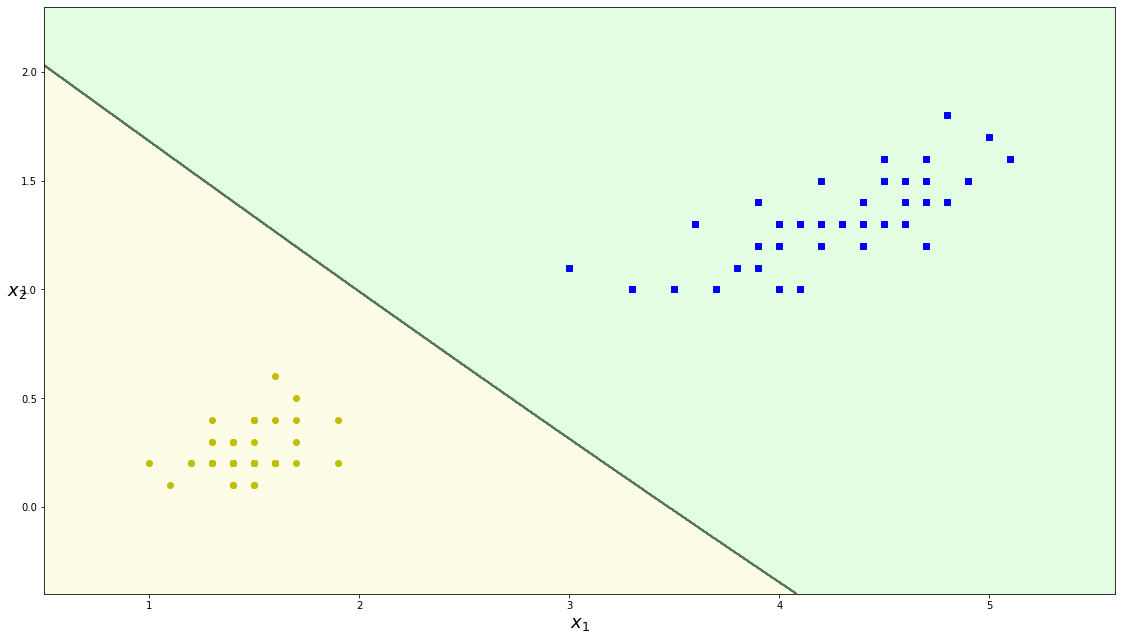

In [15]:
plt.figure(figsize=(19.20, 10.80))
plot_decision_boundary(nn, x, y, axes = [x[:, 0].min() - 0.5, x[:, 0].max() + 0.5,\
                                           x[:, 1].min() - 0.5, x[:, 1].max() + 0.5])

plt.show()

In [16]:
x, y = make_circles(n_samples=1000, noise=0.1, factor=0.5)
y = y.reshape(-1, 1)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)

In [17]:
nn = NeuralNetwork()
nn.use(log_loss, log_loss_derivative)
nn.add_layer(Linear(2, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(4, 1))
nn.add_layer(Activation(sigmoid, sigmoid_derivative))

In [18]:
nn.fit(x_train, y_train, 0.03, 20000, x_val, y_val)

******************************
Epoch 0  train_loss:0.7668380927369519, val_loss:0.7976312845858553
******************************
Epoch 2000  train_loss:0.6663323251313933, val_loss:0.6694947591476118
******************************
Epoch 4000  train_loss:0.5908006678915733, val_loss:0.5983312301730297
******************************
Epoch 6000  train_loss:0.5218048013415696, val_loss:0.5371492600766448
******************************
Epoch 8000  train_loss:0.4584538561417659, val_loss:0.4793037063278358
******************************
Epoch 10000  train_loss:0.22079210911911112, val_loss:0.22978690674535363
******************************
Epoch 12000  train_loss:0.1494718714085372, val_loss:0.16198561652300875
******************************
Epoch 14000  train_loss:0.12359007058172196, val_loss:0.13683502362269434
******************************
Epoch 16000  train_loss:0.10929181632570702, val_loss:0.12244373829515744
******************************
Epoch 18000  train_loss:0.09957170391982215

NeuralNetwork class, layers:
[Linear layer, input size:2, output size:4, Activation layer, activation function:<function tanh at 0x0000015A56E79B88>, Linear layer, input size:4, output size:1, Activation layer, activation function:<function sigmoid at 0x0000015A56E79A68>]

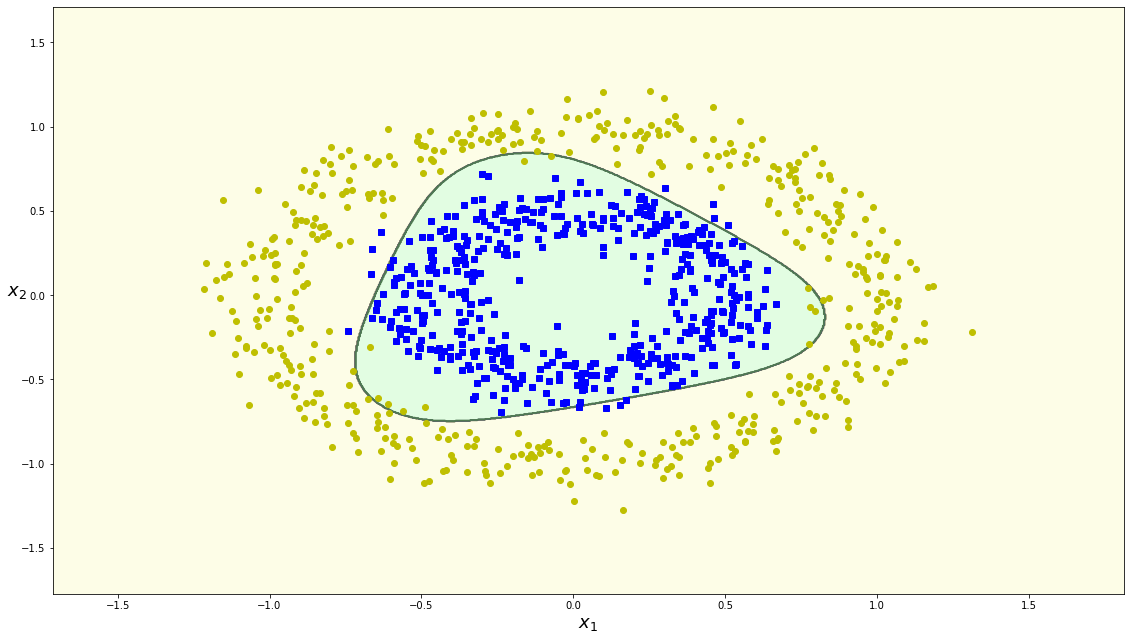

In [19]:
plt.figure(figsize=(19.20, 10.80))
plot_decision_boundary(nn, x, y, axes = [x[:, 0].min() - 0.5, x[:, 0].max() + 0.5,\
                                           x[:, 1].min() - 0.5, x[:, 1].max() + 0.5])

plt.show()

In [20]:
x, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, shift=0.1)
y = y.reshape(-1, 1)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)

In [21]:
nn = NeuralNetwork()
nn.use(log_loss, log_loss_derivative)
nn.add_layer(Linear(2, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(4, 1))
nn.add_layer(Activation(sigmoid, sigmoid_derivative))

In [22]:
nn.fit(x_train, y_train, 0.03, 10000, x_val, y_val)

******************************
Epoch 0  train_loss:0.978255636496761, val_loss:0.9590425888765814
******************************
Epoch 1000  train_loss:0.3162317725556208, val_loss:0.27001070602812066
******************************
Epoch 2000  train_loss:0.31394074878834655, val_loss:0.2661887107889839
******************************
Epoch 3000  train_loss:0.31260021000319255, val_loss:0.264368194539356
******************************
Epoch 4000  train_loss:0.31111841666331164, val_loss:0.26277656250453474
******************************
Epoch 5000  train_loss:0.307924595305804, val_loss:0.2598239541203127
******************************
Epoch 6000  train_loss:0.3029817447733308, val_loss:0.2550267709191753
******************************
Epoch 7000  train_loss:0.29620966464431936, val_loss:0.24804125760752246
******************************
Epoch 8000  train_loss:0.2815425375941514, val_loss:0.23289850213882557
******************************
Epoch 9000  train_loss:0.26767083400372615, val_l

NeuralNetwork class, layers:
[Linear layer, input size:2, output size:4, Activation layer, activation function:<function tanh at 0x0000015A56E79B88>, Linear layer, input size:4, output size:1, Activation layer, activation function:<function sigmoid at 0x0000015A56E79A68>]

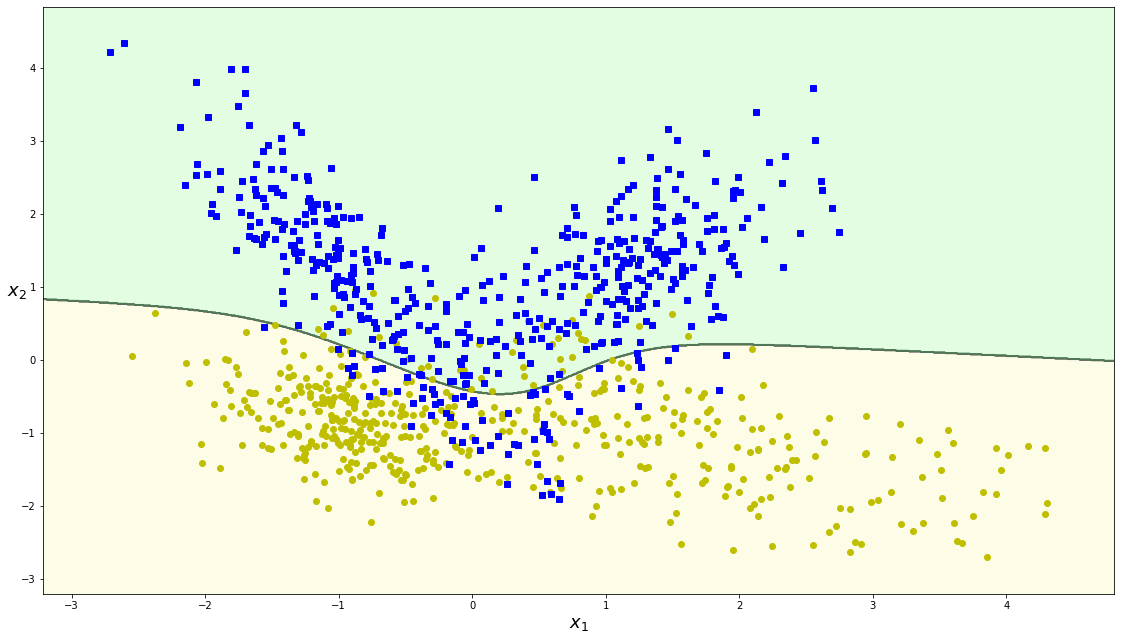

In [23]:
plt.figure(figsize=(19.20, 10.80))
plot_decision_boundary(nn, x, y, axes = [x[:, 0].min() - 0.5, x[:, 0].max() + 0.5,\
                                           x[:, 1].min() - 0.5, x[:, 1].max() + 0.5])

plt.show()

<p>Some regression</p>

In [24]:
scaler = StandardScaler()

In [25]:
data = load_boston()
x = scaler.fit_transform(data['data'])
y = data['target'].reshape(-1, 1)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)

In [26]:
nn = NeuralNetwork()
nn.use(mse, mse_derivative)
nn.add_layer(Linear(13, 6))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(6, 1))

In [27]:
nn.fit(x_train, y_train, 0.03, 1000, x_val, y_val)

******************************
Epoch 0  train_loss:561.8793647757475, val_loss:383.0947256471328
******************************
Epoch 100  train_loss:14.13548840706532, val_loss:19.886525129159093
******************************
Epoch 200  train_loss:10.77363581229309, val_loss:17.83321790873083
******************************
Epoch 300  train_loss:9.725907049263501, val_loss:17.556557547515446
******************************
Epoch 400  train_loss:9.18310845857685, val_loss:17.497248097496797
******************************
Epoch 500  train_loss:8.84250841811548, val_loss:17.455810963667197
******************************
Epoch 600  train_loss:8.5948516123884, val_loss:17.423816295856266
******************************
Epoch 700  train_loss:8.31068990044652, val_loss:17.11158631631199
******************************
Epoch 800  train_loss:8.150296071405768, val_loss:17.167117468850773
******************************
Epoch 900  train_loss:7.988864141794175, val_loss:17.249527929536125


NeuralNetwork class, layers:
[Linear layer, input size:13, output size:6, Activation layer, activation function:<function tanh at 0x0000015A56E79B88>, Linear layer, input size:6, output size:1]

In [28]:
print(r2_score(y_val, nn.predict(x_val)))

0.7459679123996231


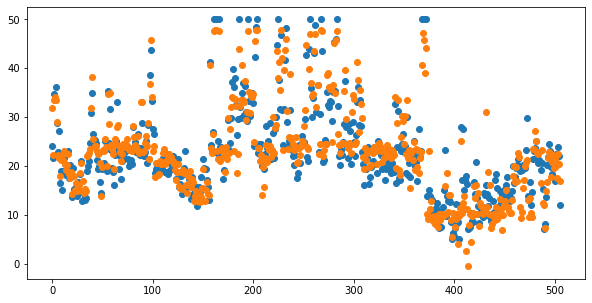

In [29]:
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y)), y)
plt.scatter(range(len(y)), nn.predict(x))
plt.show()

In [30]:
with open('./style.css') as f:
    style = f.read()
HTML(style)